# Proyek Klasifikasi Gambar: Brain Tumor MRI Dataset
- **Nama:** Mochammad Fikri Haikal Rohman
- **Email:** haikalnwn996@gmail.com

## Import Semua Packages/Library yang Digunakan

In [ ]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq

In [ ]:
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [ ]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

## Data Preparation

### Data Loading

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip

In [ ]:
!mkdir datasets

In [ ]:
train_dir = './Training'
test_dir = './Testing'
combined_dir = './datasets'


# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

In [ ]:
!rm -r Testing
!rm -r Training

### Data Preprocessing

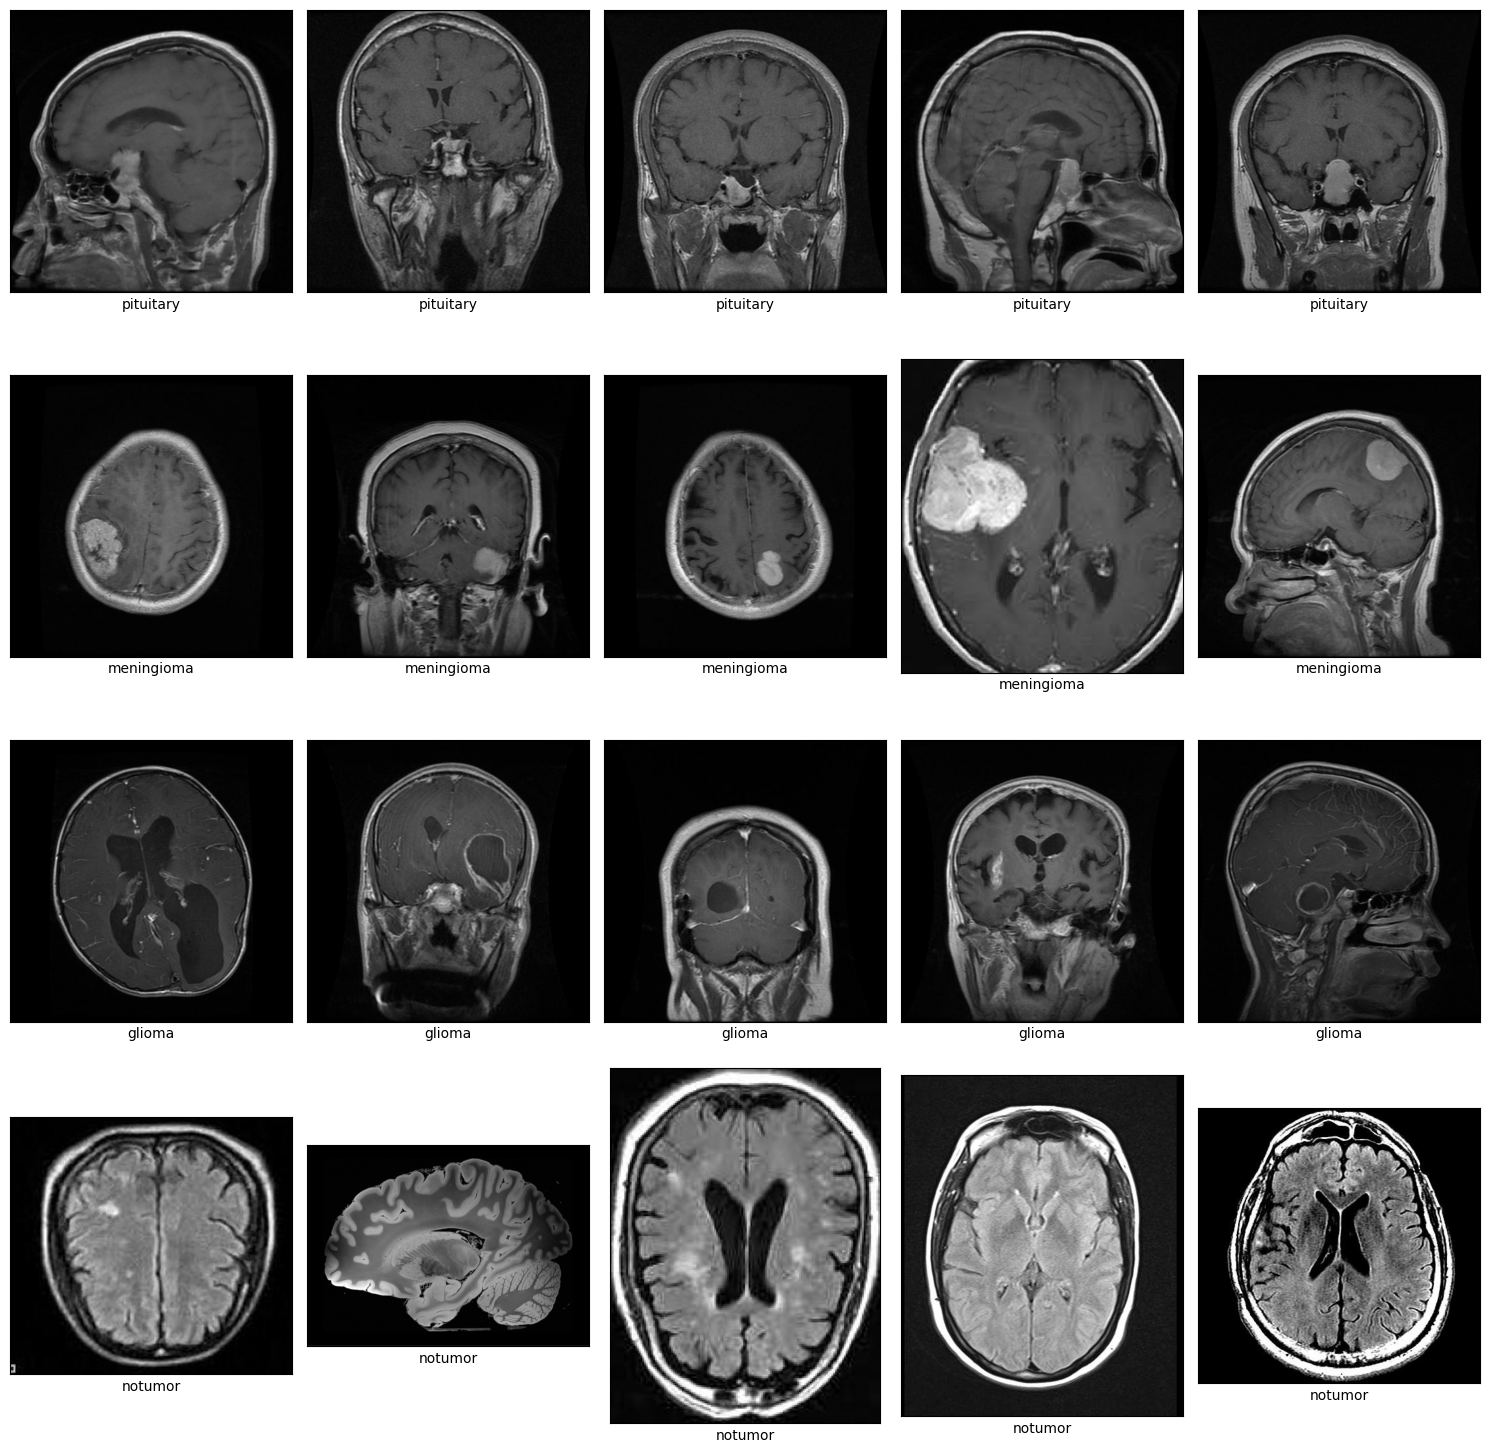

In [ ]:
# Menampilkan 5 gambar acak setiap kelas
brain_image = {}

path = "datasets/"
for i in os.listdir(path):
  brain_image[i] = os.listdir(os.path.join(path, i))

path_sub = "datasets/"

fig, axs = plt.subplots(len(brain_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
  images = np.random.choice(brain_image[class_name], 5, replace=False)

  for j, image_name in enumerate(images):
    img_path = os.path.join(path_sub, class_name, image_name)
    img = Image.open(img_path).convert("L")
    axs[i, j].imshow(img, cmap='gray')
    axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

In [ ]:
def generate_distribution(path):
  file_name = []
  labels = []
  full_path = []

  for path, subdirs, files in os.walk(path):
    for name in files:
      full_path.append(os.path.join(path, name))
      labels.append(path.split('/')[-1])
      file_name.append(name)

  distribution_train = pd.DataFrame({'path': full_path, 'file_name': file_name, 'labels': labels})

  return distribution_train

In [ ]:
training_dist = generate_distribution('./datasets')

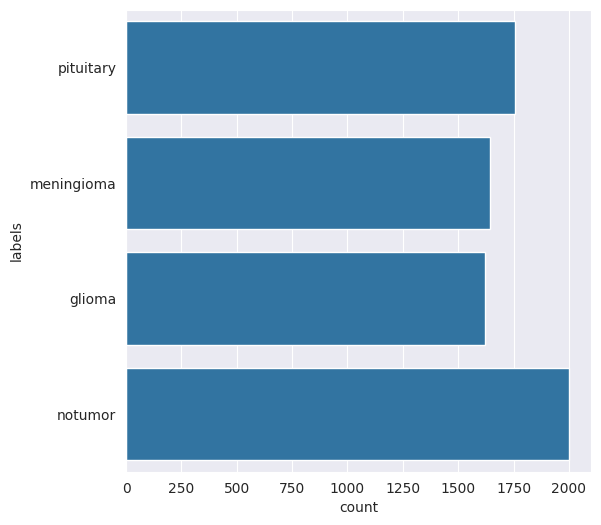

In [ ]:
# Plot distribusi gambar di setiap kelas
Label = training_dist['labels']
plt.figure(figsize=(6,6))
sns.set_style('darkgrid')
plot_data = sns.countplot(Label)

In [ ]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [ ]:
# Membuat fungsi untuk mengaugmentasi gambar
def augmented_image(images_path, images_to_generate = 500):
  transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                      'rotate clockwise': clockwise_rotation,
                      'warp shift': warp_shift,
                      'blurring image': blur_image,
                      'add brightness' : add_brightness,
                      'flip up down': flip_up_down,
                      'shear image': sheared
                    }

  augmented_path=images_path + "_augmented"

  if not os.path.exists(augmented_path):
    os.makedirs(augmented_path)
    print(f"Directory '{augmented_path}' created.")
  else:
    print(f"Directory '{augmented_path}' already exists.")

  images = []

  for im in os.listdir(images_path):
      images.append(os.path.join(images_path,im))

  i = 1

  while i<=images_to_generate:
      image=random.choice(images)
      try:
          original_image = io.imread(image)
          transformed_image=None
          n = 0
          transformation_count = random.randint(1, len(transformations))

          while n <= transformation_count:
              key = random.choice(list(transformations))
              transformed_image = transformations[key](original_image)
              n = n + 1

          new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
          transformed_image = img_as_ubyte(transformed_image)
          cv2.imwrite(new_image_path, transformed_image)
          i =i+1
      except ValueError as e:
          print('could not read the',image ,':',e,'hence skipping it.')

  shutil.copytree(augmented_path, images_path, dirs_exist_ok=True)
  shutil.rmtree(augmented_path)

In [ ]:
# Mengaugmentasi gambar
counted_labels = training_dist['labels'].value_counts()

augmented_image('./datasets/glioma', counted_labels['notumor'] - counted_labels['glioma'])
augmented_image('./datasets/meningioma', counted_labels['notumor'] - counted_labels['meningioma'])
augmented_image('./datasets/pituitary', counted_labels['notumor'] - counted_labels['pituitary'])

Directory './datasets/glioma_augmented' created.
Directory './datasets/meningioma_augmented' created.
Directory './datasets/pituitary_augmented' created.


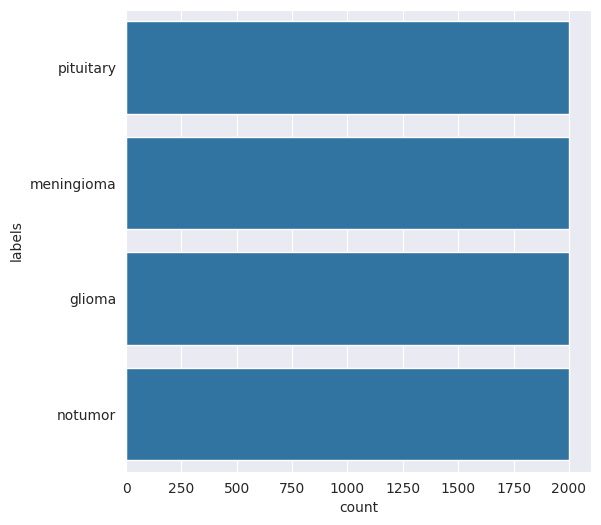

In [ ]:
training_dist = generate_distribution('./datasets')

# Plot distribusi gambar di setiap kelas
Label = training_dist['labels']
plt.figure(figsize=(6,6))
sns.set_style('darkgrid')
plot_data = sns.countplot(Label)

In [ ]:
mypath = 'datasets'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Membuat dataframe dari hasil gabungan augmentasi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

In [ ]:
df.head()

,path,file_name,labels
0,datasets/pituitary/Tr-pi_0689.jpg,Tr-pi_0689.jpg,pituitary
1,datasets/pituitary/Te-pi_0292.jpg,Te-pi_0292.jpg,pituitary
2,datasets/pituitary/Te-pi_0069.jpg,Te-pi_0069.jpg,pituitary
3,datasets/pituitary/Tr-pi_1147.jpg,Tr-pi_1147.jpg,pituitary
4,datasets/pituitary/Tr-pi_1015.jpg,Tr-pi_1015.jpg,pituitary


In [ ]:
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

In [ ]:
datasource_path = './datasets'
dataset_path = './final-dataset'

In [ ]:
# Membuat folder baru berdasarkan tipe gambar (testing/training)
for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## Modelling

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=10,
    brightness_range=(0.85, 1.15),
    width_shift_range=0.002,
    height_shift_range=0.002,
    shear_range=12.5,
    zoom_range=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

TRAIN_DIR = os.path.join(dataset_path, 'train')
TEST_DIR = os.path.join(dataset_path, 'test')

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150, 150),
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150, 150),
                                                   color_mode='grayscale',
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150, 150),
                                                  color_mode='grayscale',
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 5442 images belonging to 4 classes.
Found 958 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.


In [ ]:
model_1 = Sequential()

# ========== BLOCK 1 ==========
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# ========== BLOCK 2 ==========
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# ========== BLOCK 3 ==========
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# ========== CLASSIFICATION HEAD ==========
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

model_1.add(Dense(4, activation='softmax'))

model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,076 (5.35 MB)

 Trainable params: 1,402,884 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
from sklearn.utils import class_weight

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    min_delta=0.001,
    mode='max',
    verbose=1
)

In [ ]:
history_1 = model_1.fit(train_generator,
                        epochs=40,
                        batch_size=32,
                        validation_data=validation_generator,
                        callbacks=[early_stopping]
                        )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.4610 - loss: 1.4825 - val_accuracy: 0.2693 - val_loss: 2.9625
Epoch 2/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.6374 - loss: 0.9168 - val_accuracy: 0.3956 - val_loss: 1.9055
Epoch 3/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.6864 - loss: 0.8067 - val_accuracy: 0.5605 - val_loss: 1.0170
Epoch 4/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.6978 - loss: 0.7513 - val_accuracy: 0.7171 - val_loss: 0.6639
Epoch 5/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.7183 - loss: 0.7062 - val_accuracy: 0.7443 - val_loss: 0.6386
Epoch 6/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.7355 - loss: 0.6805 - val_accuracy: 0.7568 - val_loss: 0.5714
Epoch 7/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.7530 - loss: 0.6358 - val_accuracy: 0.7589 - val_loss: 0.5440
Epoch 8/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.7462 - loss: 0.6073 - val_accu

## Evaluasi dan Visualisasi

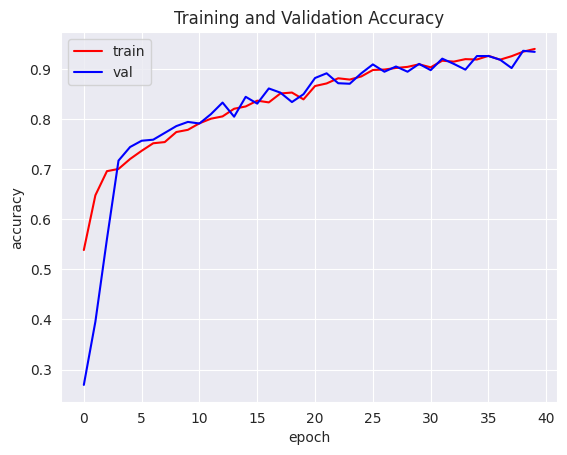

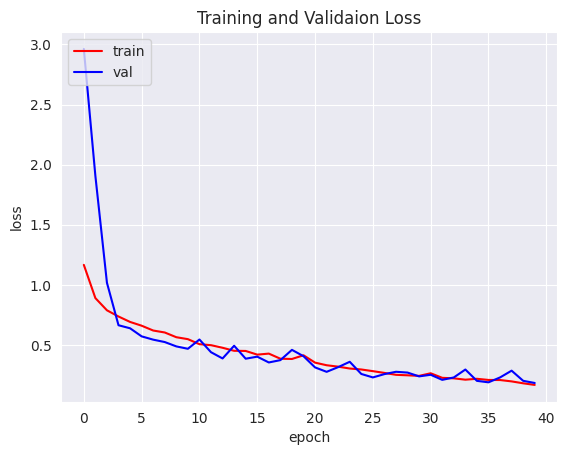

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1600/1600 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step


<Figure size 1000x800 with 0 Axes>

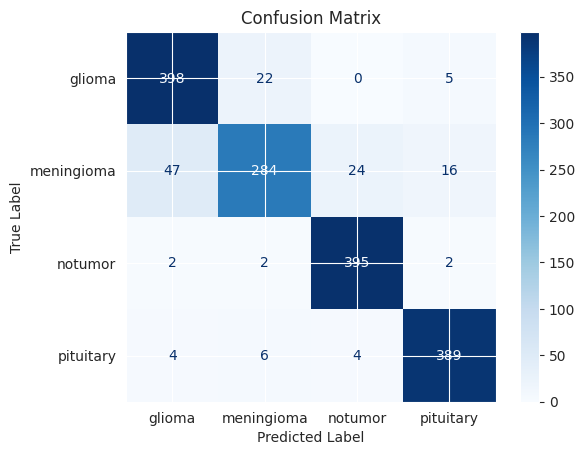

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_pred = model_1.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Konversi Model

## Saved Model

In [ ]:
model_1.export('/content/saved_model')

In [ ]:
from google.colab import files
shutil.make_archive('/content/saved_model', 'zip', '/content/saved_model')

files.download('/content/saved_model.zip')

## tfjs

In [ ]:
import tensorflowjs as tfjs
import os

saved_model_path = 'saved_model/'
tfjs_model_dir = 'tfjs_model'

if not os.path.exists(tfjs_model_dir):
    os.makedirs(tfjs_model_dir)

tfjs.converters.convert_tf_saved_model(
    saved_model_path,
    tfjs_model_dir,
    strip_debug_ops=True
)

print(f"Model TensorFlow.js berhasil disimpan di: {tfjs_model_dir}")

Model TensorFlow.js berhasil disimpan di: tfjs_model


In [ ]:
from google.colab import files
shutil.make_archive('/content/tfjs_model', 'zip', '/content/tfjs_model')

files.download('/content/tfjs_model.zip')

## tflite

In [ ]:
import tensorflow as tf
import os
import shutil

saved_model_path = 'saved_model/'

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)

tflite_model = converter.convert()

tflite_dir = 'tflite'
if not os.path.exists(tflite_dir):
    os.makedirs(tflite_dir)

tflite_model_path = os.path.join(tflite_dir, 'model.tflite')
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

label_file_path = os.path.join(tflite_dir, 'label.txt')
with open(label_file_path, 'w') as f:
  pass

print(f"Model TensorFlow Lite berhasil disimpan di: {tflite_model_path}")
print(f"File label.txt berhasil dibuat di: {label_file_path}")

Model TensorFlow Lite berhasil disimpan di: tflite/model.tflite
File label.txt berhasil dibuat di: tflite/label.txt


In [ ]:
from google.colab import files
shutil.make_archive('/content/tflite', 'zip', '/content/tflite')

files.download('/content/tflite.zip')